In [1]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  #'last', 'last_expr'

In [2]:
import sys
sys.path.insert(0, '/nas/xd/projects/transformers/src')
import os
os.environ['HF_HOME'] = '/raid3/xd/.cache/torch'  # deliberately set this wrong path to avoid migrating cache
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="8,7"

from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter
from datetime import datetime
from io import StringIO
from dataclasses import dataclass, fields
import itertools
from itertools import chain
import math
from functools import reduce, partial
from collections.abc import Iterable
from collections import namedtuple 
import traceback

# from multiprocessing import Pool
# from torch.multiprocessing import Pool
# torch.multiprocessing.set_start_method('spawn', force=True)
from multiprocessing.dummy import Pool

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader

In [3]:
# from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, GPT2Tokenizer#, pipeline
# from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
# from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration
# from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed, AdamW

In file_utils.py: default_cache_path = /raid3/xd/.cache/torch/hub


In [4]:
sys.path.insert(0, '/nas/xd/projects/PyFunctional')
from functional import seq
from functional.pipeline import Sequence
from fn import _ as __

In [5]:
from common_utils import Timer
with Timer('common_utils'): from common_utils import *
with Timer('utils'): from utils import *
with Timer('child_utils'): from child_utils import *
from child_utils import _cxt2str, _item2str
with Timer('child_utils'): from child_frames import *
with Timer('model_utils'): from model_utils import *

common_utils ... done 0:00:00.000029
utils ... done 0:00:00.018304
child_utils ... path = /nas/shawn_guo/miniconda3/envs/torch1.7/lib/python3.7/site-packages/pattern/text/en/en-verbs.txt
done 0:00:08.367252
child_utils ... done 0:00:00.014166
model_utils ... done 0:00:06.395314


In [7]:
torch.set_grad_enabled(False);# 设置不求导

In [8]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
# cache_dir = '/mnt/nvme1/xd/.cache/torch/transformers/'  # for gpt-j-6B on elderberry
proxies = {'http': '192.168.50.1:1081'} 

In [9]:
# curl -x http://192.168.50.1:1081 -L -O [-C -] https://huggingface.co/google/ul2/resolve/main/pytorch_model.bin  # -C for 断点续传
s2s_model_names = ['google/t5-xl-lm-adapt', 'google/t5-xxl-lm-adapt', 'bigscience/T0p', 'bigscience/T0_3B', 
    'allenai/tk-instruct-3b-pos', 'allenai/tk-instruct-3b-def-pos', 'google/ul2']
gpt_model_names = ['EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-neox-20b', 'EleutherAI/gpt-neox-20b/cpu']#, 'gpt2-xl', 'gpt2']
#                    'KoboldAI/fairseq-dense-6.7B', 'KoboldAI/fairseq-dense-13B']
for model_name in s2s_model_names[:0] + gpt_model_names[:1]:#, 'gpt2-xl', 'EleutherAI/gpt-neo-1.3B', 'KoboldAI/fairseq-dense-6.7B']:
    if model_name in models: continue
    with Timer(model_name):
        model_cls = AutoModelForCausalLM if any(s in model_name for s in ['gpt', 'fairseq-dense']) else T5ForConditionalGeneration
        # _cache_dir = cache_dir.replace('/nas/', '/nas2/') if 'gpt' not in model_name else cache_dir
        kwargs = dict(cache_dir=cache_dir, proxies=proxies, low_cpu_mem_usage=True)
        if '/cpu' in model_name or 'gpt-j' not in model_name and 'gpt-neox' not in model_name:
            model = model_cls.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir, proxies=proxies)
        elif 'gpt-j' in model_name:
            device = 1
            model = model_cls.from_pretrained(model_name, revision="float16", torch_dtype=torch.float16, **kwargs).to(device)
        elif 'gpt-neox' in model_name:
            device = 0; device_map = {'gpt_neox': device, 'embed_out': device}
            model = model_cls.from_pretrained(model_name, device_map=device_map, load_in_8bit=True, **kwargs)
        if hasattr(model.config, 'use_cache'): model.config.use_cache = False  # save GPU mem
        # if model_name in ['EleutherAI/gpt-neox-20b']: model = model.half()
        tokenizer = AutoTokenizer.from_pretrained(model_name.replace('/cpu', ''), cache_dir=cache_dir)
        unify(model)
        models[model_name] = model, tokenizer#, device

EleutherAI/gpt-j-6B/cpu ... done 0:09:26.673930


In [597]:
import openai
openai.api_key = open('/nas/xd/projects/openai_api_keys.txt').readlines()[2].split()[0]
response = openai.Completion.create(engine='text-davinci-002', prompt='Once upon a time',
    max_tokens=20, echo=True, logprobs=5)
print(response.choices[0].text)

Once upon a time, there was a tribe of smart, resourceful people.

This tribe lived in a land


In [10]:
def get_openai_model(engine):
    def forward(input_ids):#, attention_mask=None):
        text = tokenizer.decode(input_ids[0])
        response = openai.Completion.create(engine=engine, prompt=text, max_tokens=0, echo=True, logprobs=5)
        return Outputs(logits=response.choices[0].logprobs)
    return forward
    
tokenizer0 = GPT2Tokenizer.from_pretrained('gpt2', cache_dir=cache_dir)
engines = ['text-babbage-001', 'text-curie-001', 'text-davinci-001', 'text-davinci-002'][1:] #+ \
#     ['curie', 'curie:2020-05-03', 'curie-instruct-beta', 'text-curie-001'] + \
#     ['davinci', 'davinci:2020-05-03', 'davinci-instruct-beta', 'davinci-instruct-beta:2.0.0', 'text-davinci-001', 'text-davinci-002']
for engine in engines: models[engine] = get_openai_model(engine), tokenizer0

In [10]:
model_name = gpt_model_names[0]
model, tokenizer = models[model_name]
# unify(model)
# if model_name == 'EleutherAI/gpt-neox-20b/': and model_name + '/cpu' in models:
#     unify(models[model_name + '/cpu'][0])

blocks = model.transformer.h
attn0 = blocks[0].attn
ln_f = model.transformer.ln_f
L, H, embed_dim = len(blocks), attn0.num_heads, attn0.embed_dim

In [13]:
_girls = [name for name in girls if max(len(tokenizer.tokenize(name)), len(tokenizer.tokenize(' ' + name))) == 1]
_boys = [name for name in boys if max(len(tokenizer.tokenize(name)), len(tokenizer.tokenize(' ' + name))) == 1]
_boys = sample(_boys, len(_girls))
def persons(): return _boys + _girls

In [14]:
# I = Identity; M = Mophism; A = Aggregation; C = CMP; G = GroupBy; l = local
patterns = ['M', 'A?', 'IA', 'MA',
    'IlI', 'MlI', 'IlM', 'MlM', 'IlMlI',
    'IlA', 'MlA', 'IlC', 'MlC', 'AlI', 'GIlI']
# NE types: boy girl planet letter number month day
# TreeSet(name_genders), TreeSet(name_prons), # resolve iu in speech,  item[0]
# BijectSet(place_landmarks), BijectSet(sport_players) # count, item[1]

In [15]:
def ith_gen(rels, cxt_len=3):
    hop = 0; cxt = sample(rels[hop][0].codom(), cxt_len)
    query, candidates, ans = None, (cxt, cxt), cxt[1]
    return cxt, query, candidates, ans

In [74]:
tasks[-2]

(<function __main__.<lambda>()>,
 <function child_utils.MlM_gen(rels, cxt_len=3)>,
 functools.partial(<function _cxt2str at 0x7f4aa502e290>, sep='. ', item2str=<function <lambda> at 0x7f4aa58a4ef0>),
 <function __main__.<lambda>(q, _)>,
 "'s")

In [18]:
tasks = [
    # (lambda: [[EqSet(uppercase).equal], ], ith_gen, partial(cxt2str, sep=' '), lambda q, _: '', 'Ġ->'), 
    (lambda: [[TreeSet(types_of_things).child], [EqSet(persons).equal]], g2c(MlM_gen, labels=['Yes', 'No']),
        partial(_cxt2str, sep='. ', item2str=lambda item, vocab: f"The {item[0]} is {item[1]}'s"),
        # lambda query, vocab: f'So does the {query[0]} belong to {query[1]}',
        lambda query, vocab: f'{query[0]} {query[1]}'#f"So is the {query[0]} {query[1]}'s",
    ), 
    (lambda: [[TreeSet(types_of_things).child], [EqSet(persons).equal]], MlM_gen,
     # partial(cxt2str, prefix='There are ', item2str=lambda i, _: f"{i[1]}'s {i[0]}"), lambda q, _: f"So whose {q}", '?' # worse 
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f"The {i[0]} is {i[1]}'s"), lambda q, _: f'So the {q} belongs', 'Ġto'
    ),
    (lambda: [[EqSet(persons).equal], [TreeSet(types_of_things).parent]], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} has {add_a_or_an(i[1])}'), lambda q, _: f'{q}', "'s"
    ), # t: 21-5, 15-8, 19. p: 16-7, 18-5, [3-12, 13-7]. p+: 16-7, 16-0. 13-7:induction head qk, thing->type ov
    (lambda: [EqSet(persons).use('equal'), TreeSet(types_of_things).use('equal')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} has {wrap_noun(i[1])}'), lambda q, _: f'{q}', "'s"
    ),
    (lambda: [EqSet(persons).use('equal'), TreeSet(types_of_things).use('parent')], MlM_gen,
     partial(_cxt2str, sep='. ', item2str=lambda i, _: f"{i[0]} has {wrap_noun(i[1])}"), lambda q, _: f'{q}', "'s"
    #  partial(_cxt2str, sep='. ', item2str=lambda i, _: f"{i[0]}'s {i[1]}"), lambda q, _: f'{q}', "'s"
    ),
#     (lambda: [[EqSet(persons).equal], [SymSet(person_adjs).opposite]], g2c(MlM_gen),
#      partial(cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} is {i[1]}'), lambda q, _: f'So is {q[0]} {q[1]}', '?'
#     ), # c << g. cxt_len=3->2, gpt-j/neox better, davinci-001/002 worse!?
#     (lambda: [[EqSet(persons).equal], [SymSet(person_adjs).opposite]], MlM_gen,
#      partial(cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} is {i[1]}'), lambda q, _: f'So {q} is', 'Ġnot'
#     ), # verbose acc: gpj-j > curie-001 > davinci-001 > gpt-neox!? abstract acc: gpt-neox > gpt-j. all poor (inc. davinci-002!)
#     (lambda: [[SymSet(person_adjs).equal], [EqSet(persons).equal]], MlM_gen,
#      partial(cxt2str, item2str=lambda i, _: f'{i[1]} is {i[0]}'), lambda q, _: f'So who is {}', '?'
#     ),  # gpt-neox good
#     (lambda: [[EqSet(persons).equal], [SymSet(person_adjs).equal]], MlM_gen,
#      partial(cxt2str, prefix='There are ', item2str=lambda i, _: f'{i[1]} {i[0]}'), lambda q, _: f'So {q}', 'Ġis'
#     ),
# #     (lambda: [[EqSet(persons).equal], [PoSet(digits).equal], [EqSet(persons).equal]], g2c(IlMlI_gen),
# #         partial(cxt2str, item2str=lambda item, vocab: f'{item[0]} {item[1]}'),
# #         lambda query, vocab: f'{query[0]} and {query[1]} are same?'
# #     ),
# #     (lambda: [[EqSet(persons).equal], [PoSet(digits).equal], [EqSet(persons).equal]], lMlI_gen,
# #         partial(cxt2str, item2str=lambda item, vocab: f'{item[0]} is {item[1]}'),
# #         lambda query, vocab: f'{query} is the same as', # bare query is better for gpt-neox!?
# #     ),
#     (lambda: [[EqSet(persons).equal], [BijectSet(capabilities).proj]], partial(MlM_gen, cxt_len=2),
#      partial(cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} has {add_a_or_an(i[1])}'), lambda q, _: f'So {q}', 'Ġcan'
#     ),  # even davinci-001 is not very good
#     (lambda: [[EqSet(persons).equal], [BijectSet([(vt.did, vt.does) for vt in verb_tenses]).proj]], MlM_gen,
#      partial(cxt2str, sep='. '), lambda q, _: f'{q}', 'Ġusually'
#     ), # best performance among all tasks by all models. abstract > verbose
#     (lambda: [[EqSet(persons).equal], [BijectSet(country2capital).inv_proj]], MlM_gen,
#      partial(cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} lives in {i[1]}'), lambda q, _: f'{q} is', 'Ġfrom'
#     ),
#     (lambda: [[EqSet(persons).equal], [BijectSet(city2resident).proj]], MlM_gen,
#      partial(cxt2str, sep='. ', item2str=lambda i, _: f'{i[0]} lives in {i[1]}'), lambda q, _: f'{q}', 'Ġis'
#     ), # a little worse than capital -> country
]

In [98]:
vocab_fn, example_gen_fn = tasks[-2][:2]

vocab = vocab_fn()


In [125]:
vocab[1].relations[0]._dict

defaultdict(list,
            {'chicken': ['chicken'],
             'duck': ['duck'],
             'goose': ['goose'],
             'dog': ['dog'],
             'lion': ['lion'],
             'cow': ['cow'],
             'donkey': ['donkey'],
             'horse': ['horse'],
             'sheep': ['sheep'],
             'goat': ['goat'],
             'bear': ['bear'],
             'tiger': ['tiger'],
             'cat': ['cat'],
             'zebra': ['zebra'],
             'pig': ['pig'],
             'giraffe': ['giraffe'],
             'monkey': ['monkey'],
             'rabbit': ['rabbit'],
             'elephant': ['elephant'],
             'wolf': ['wolf'],
             'deer': ['deer'],
             'fox': ['fox'],
             'gorilla': ['gorilla'],
             'kangaroo': ['kangaroo'],
             'squirrel': ['squirrel'],
             'mouse': ['mouse'],
             'apple': ['apple'],
             'banana': ['banana'],
             'pear': ['pear'],
             'grapes'

In [111]:
MlM_gen(vocab,2)

OrderedDict([(0, ['Joshua', 'Jake'])])


([('Jake', 'hamburger'), ('Joshua', 'spaghetti')],
 'Joshua',
 (['hamburger', 'spaghetti'], ['hamburger', 'spaghetti']),
 ('Joshua', 'spaghetti', 'spaghetti'))

In [112]:
vocab[1].relations

In [66]:
del query_openai; from openai_utils import query_openai

In [67]:
len(getattr(query_openai, 'cache', []))

59

In [83]:
for v in tasks[-2][0]():
    print(v)

persons.EqSet.equal
types_of_things.TreeSet.equal


In [85]:
# len(getattr(query_openai, 'cache', []))
nrows, k_shot = 10, 3
results = {}
a = None
for task, cxt_len, abstract in tqdm(list(itertools.product(tasks[-2:], [1, 2], [0, 1]))):
    seed(49)
    args = dict(cxt_len=cxt_len, abstract=abstract)
    res_key = f"{task2str(task)} ({', '.join(f'{k}={v}' for k, v in args.items())})"
    # if not ('TreeSet.equal' in res_key and cxt_len == 1): continue
    
    batch_size = 2; verbose = batch_size <= 2
    if verbose: print(f'===== {res_key} =====')
    a = [generate(task, verbose=False, plot=False, nrows=nrows, **args)
                                            for i in range(batch_size)]
    # print()

    # all_examples, texts, bos_tokens = zip(*[generate(task, verbose=False, plot=False, nrows=nrows, **args)
    #                                         for i in range(batch_size)])
    # print(all_examples[0])
    # print(texts[0])
    break
    

  0%|          | 0/8 [00:00<?, ?it/s]

===== MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=1, abstract=0) =====


In [91]:
vocabs, examples = make_examples(task, nrows=10, cxt_len=1)

In [97]:
print(a[])

([[[('Phoenix', 'wolf')], 'Phoenix', (['wolf'], ['wolf']), ('Phoenix', 'wolf', 'wolf')], [[('Jay', 'duck')], 'Jay', (['duck'], ['duck']), ('Jay', 'duck', 'duck')], [[('Kelly', 'cat')], 'Kelly', (['cat'], ['cat']), ('Kelly', 'cat', 'cat')], [[('Ben', 'whiskey')], 'Ben', (['whiskey'], ['whiskey']), ('Ben', 'whiskey', 'whiskey')], [[('Joy', 'hamburger')], 'Joy', (['hamburger'], ['hamburger']), ('Joy', 'hamburger', 'hamburger')], [[('Steven', 'pistol')], 'Steven', (['pistol'], ['pistol']), ('Steven', 'pistol', 'pistol')], [[('Tyler', 'elephant')], 'Tyler', (['elephant'], ['elephant']), ('Tyler', 'elephant', 'elephant')], [[('Jose', 'pink')], 'Jose', (['pink'], ['pink']), ('Jose', 'pink', 'pink')], [[('Summer', 'pistol')], 'Summer', (['pistol'], ['pistol']), ('Summer', 'pistol', 'pistol')], [[('Blake', 'gorilla')], 'Blake', (['gorilla'], ['gorilla']), ('Blake', 'gorilla', 'gorilla')]], "Phoenix has a wolf. Phoenix's wolf\nJay has a duck. Jay's duck\nKelly has a cat. Kelly's cat\nBen has whi

In [95]:
examples[0]

[[('Jackson', 'steak')],
 'Jackson',
 (['steak'], ['steak']),
 ('Jackson', 'steak', 'steak')]

In [90]:
a[0][2]

"'s"

In [64]:
bos_tokens

("'s", "'s")

In [49]:
all_examples

([[[('Ruby', 'pizza'), ('Denver', 'grenade')],
   'Ruby',
   (['food', 'weapon'], ['pizza', 'grenade']),
   ('Ruby', 'pizza', 'food')],
  [[('Robin', 'burger'), ('Steven', 'lime')],
   'Robin',
   (['food', 'fruit'], ['burger', 'lime']),
   ('Robin', 'burger', 'food')],
  [[('Jennifer', 'lion'), ('Neil', 'tea')],
   'Neil',
   (['animal', 'drink'], ['lion', 'tea']),
   ('Neil', 'tea', 'drink')],
  [[('Jacob', 'kangaroo'), ('Egypt', 'papaya')],
   'Jacob',
   (['animal', 'fruit'], ['kangaroo', 'papaya']),
   ('Jacob', 'kangaroo', 'animal')],
  [[('Steven', 'green'), ('Cole', 'blueberries')],
   'Steven',
   (['color', 'fruit'], ['green', 'blueberries']),
   ('Steven', 'green', 'color')],
  [[('Royal', 'durian'), ('June', 'pistol')],
   'June',
   (['fruit', 'weapon'], ['durian', 'pistol']),
   ('June', 'pistol', 'weapon')],
  [[('Lee', 'whiskey'), ('Jake', 'kangaroo')],
   'Lee',
   (['drink', 'animal'], ['whiskey', 'kangaroo']),
   ('Lee', 'whiskey', 'drink')],
  [[('Andrew', 'handgun'

  0%|          | 0/8 [00:00<?, ?it/s]

===== MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=1, abstract=0) =====
*Ġstrawberries 0.123 {'Ġstrawberries': 0.123, 'Ġstrawberry': 0.058, 'Ġa': 0.049} 	 Ruby has strawberries. Ruby's strawberries
*Ġpistol 0.757 {'Ġpistol': 0.757, 'Ġa': 0.078, 'Ċ': 0.023} 	 Jamie has a pistol. Jamie's pistol
*Ġelephant 0.947 {'Ġelephant': 0.947, 'Ċ': 0.019, 'ĠElephant': 0.006} 	 Jane has an elephant. Jane's elephant
*Ġsheep 0.98 {'Ġsheep': 0.98, 'Ċ': 0.006, 'Ġlamb': 0.001} 	 Robert has a sheep. Robert's sheep
*Ġcoffee 0.967 {'Ġcoffee': 0.967, 'Ġcup': 0.009, 'Ċ': 0.002} 	 Jamie has coffee. Jamie's coffee
*Ġbeer 0.992 {'Ġbeer': 0.992, 'Ċ': 0.001, 'ĠBeer': 0.001} 	 Andy has beer. Andy's beer
*Ġpink 0.987 {'Ġpink': 0.987, 'Ċ': 0.002, 'Ġp': 0.001} 	 Marco has pink. Marco's pink
*Ġdog 0.987 {'Ġdog': 0.987, 'Ġa': 0.004, 'Ġdo': 0.003} 	 Adam has a dog. Adam's dog
*Ġdeer 0.996 {'Ġdeer': 0.996, 'Ġa': 0.001, 'Ġde': 0.001} 	 Sam has a deer. Sam's deer
*Ġplum 0.996 {'Ġplum': 0.996, 'Ġpl': 0

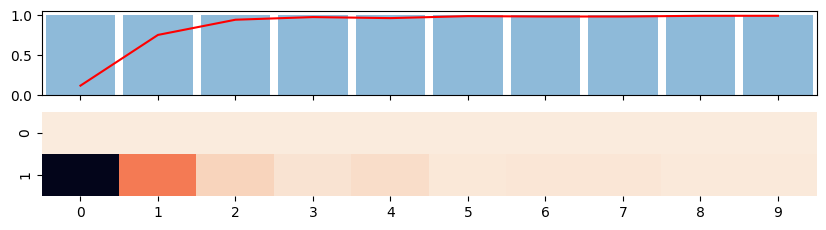

*Ġwine 0.253 {'Ġwine': 0.253, 'Ġgot': 0.041, 'Ġwife': 0.024} 	 Bear has wine. Bear's wine
*Ġmango 0.801 {'Ġmango': 0.801, 'Ċ': 0.115, 'Ġwine': 0.015} 	 Russell has a mango. Russell's mango
*Ġhamb 0.911 {'Ġhamb': 0.911, 'Ċ': 0.066, 'Ġburger': 0.011} 	 Charlie has a hamburger. Charlie's hamburger
*Ġcocktail 0.988 {'Ġcocktail': 0.988, 'Ċ': 0.003, 'Ġcocktails': 0.002} 	 Ray has a cocktail. Ray's cocktail
*Ġvodka 0.971 {'Ġvodka': 0.971, 'Ċ': 0.006, 'Ġv': 0.005} 	 Alexander has vodka. Alexander's vodka
*Ġcat 0.988 {'Ġcat': 0.988, 'Ġk': 0.002, 'Ġkitten': 0.001} 	 Marie has a cat. Marie's cat
*Ġgir 0.995 {'Ġgir': 0.995, 'Ġg': 0.001, 'Ċ': 0.001} 	 Sam has a giraffe. Sam's giraffe
*Ġbanana 0.996 {'Ġbanana': 0.996, 'Ġbananas': 0.001, 'Ċ': 0.0} 	 Israel has a banana. Israel's banana
*Ġapple 0.995 {'Ġapple': 0.995, 'ĠApple': 0.001, 'Ġapples': 0.001} 	 Dash has an apple. Dash's apple
*Ġrifle 0.996 {'Ġrifle': 0.996, 'Ġgun': 0.001, 'Ċ': 0.0} 	 Jose has a rifle. Jose's rifle
0.010370421223342419


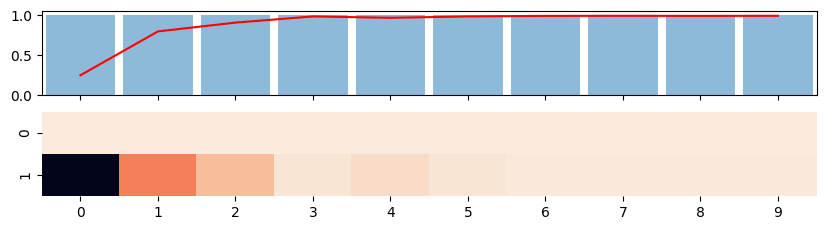

 12%|█▎        | 1/8 [00:13<01:33, 13.43s/it]

===== MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=1, abstract=1) =====
*Ġstrawberries 0.03 {'Ġstrawberries': 0.03, 'Ġ1': 0.026, 'Ġ$': 0.022} 	 strawberries -> strawberries
*Ġpistol 0.363 {'Ġpistol': 0.363, 'Ġpistols': 0.058, 'Ġrevolver': 0.044} 	 pistol -> pistol
*Ġelephant 0.832 {'Ġelephant': 0.832, 'Ġeleph': 0.016, 'Ġelephants': 0.016} 	 elephant -> elephant
*Ġsheep 0.945 {'Ġsheep': 0.945, 'Ġshe': 0.007, 'Ġelephant': 0.004} 	 sheep -> sheep
*Ġcoffee 0.872 {'Ġcoffee': 0.872, 'Ġco': 0.009, 'Ġcoff': 0.007} 	 coffee -> coffee
*Ġbeer 0.973 {'Ġbeer': 0.973, 'Ġbeers': 0.002, 'Ġcoffee': 0.002} 	 beer -> beer
*Ġpink 0.957 {'Ġpink': 0.957, 'Ġpurple': 0.007, 'Ġp': 0.004} 	 pink -> pink
*Ġdog 0.928 {'Ġdog': 0.928, 'Ġdo': 0.012, 'Ġpuppy': 0.009} 	 dog -> dog
*Ġdeer 0.992 {'Ġdeer': 0.992, 'Ġde': 0.001, 'Ġdog': 0.001} 	 deer -> deer
*Ġplum 0.989 {'Ġplum': 0.989, 'Ġpl': 0.008, 'Ġpurple': 0.001} 	 plum -> plum
0.05154256895184517


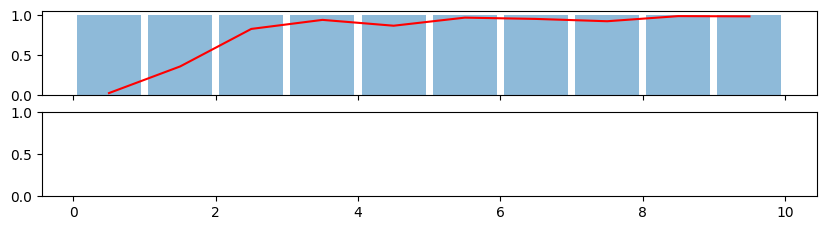

 Ġwine 0.006 {'Ġhttp': 0.024, 'Ġ/': 0.017, 'Ġub': 0.016} 	 wine -> wine
 Ġmango 0.205 {'Ġwine': 0.273, 'Ġmango': 0.205, 'Ġm': 0.023} 	 mango -> mango
*Ġhamb 0.874 {'Ġhamb': 0.874, 'Ġburger': 0.069, 'Ġham': 0.012} 	 hamburger -> hamburger
*Ġcocktail 0.844 {'Ġcocktail': 0.844, 'Ġcocktails': 0.013, 'Ġdrink': 0.012} 	 cocktail -> cocktail
*Ġvodka 0.922 {'Ġvodka': 0.922, 'Ġv': 0.047, 'Ġ': 0.002} 	 vodka -> vodka
*Ġcat 0.777 {'Ġcat': 0.777, 'Ġk': 0.026, 'Ġdog': 0.023} 	 cat -> cat
*Ġgir 0.963 {'Ġgir': 0.963, 'Ġg': 0.015, 'Ġcat': 0.001} 	 giraffe -> giraffe
*Ġbanana 0.989 {'Ġbanana': 0.989, 'Ġban': 0.002, 'Ġbananas': 0.001} 	 banana -> banana
*Ġapple 0.985 {'Ġapple': 0.985, 'Ġbanana': 0.004, 'Ġfruit': 0.002} 	 apple -> apple
*Ġrifle 0.996 {'Ġrifle': 0.996, 'Ġr': 0.0, 'ĠRifle': 0.0} 	 rifle -> rifle
0.08166785538196564


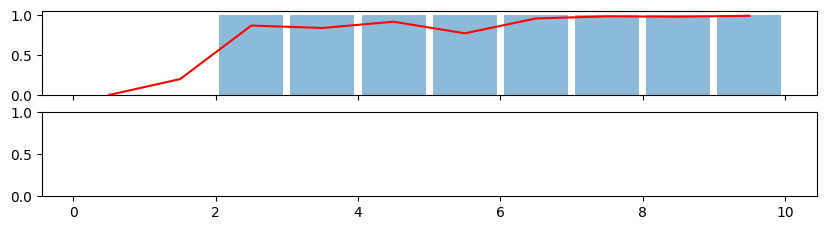

 25%|██▌       | 2/8 [00:23<01:09, 11.53s/it]

===== MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0) =====
In query_openai: gun: There ->  is a gun.
In query_openai: juice: There ->  is juice.
In query_openai: duck: There ->  is a duck.
In query_openai: revolver: There ->  is a revolver.
In query_openai: shotgun: There ->  is a shotgun.
In query_openai: lemon: There ->  is a lemon.
In query_openai: purple: There ->  is a purple pen.
In query_openai: lion: There ->  is a lion.
In query_openai: whiskey: There ->  is whiskey.
In query_openai: blueberries: There ->  are blueberries.
In query_openai: zebra: There ->  is a zebra.
In query_openai: durian: There ->  is a durian.
In query_openai: mouse: There ->  is a mouse.
In query_openai: steak: There ->  is a steak.
In query_openai: gorilla: There ->  is a gorilla.
In query_openai: lime: There ->  is a lime.
In query_openai: yellow: There ->  is yellow.
In query_openai: squirrel: There ->  is a squirrel.
In query_openai: goat: There ->  is a goat.
In 

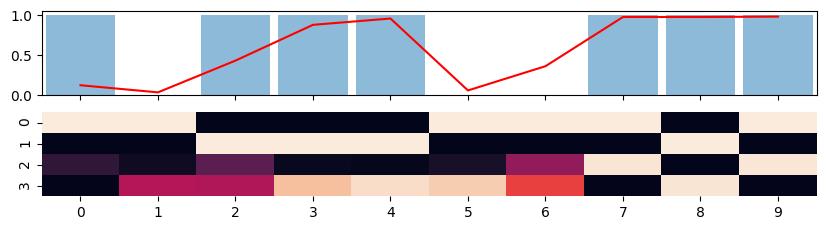

*Ġsheep 0.255 {'Ġsheep': 0.255, 'Ġz': 0.078, 'Ġa': 0.044} 	 Ari has a sheep. Morgan has a zebra. Ari's sheep
 Ġdur 0.06 {'Ġz': 0.492, 'Ċ': 0.101, 'Ġsheep': 0.08} 	 Carter has a durian. Jessica has beer. Carter's durian
*Ġmouse 0.964 {'Ġmouse': 0.964, 'Ċ': 0.013, 'Ġbeer': 0.004} 	 Eva has a mouse. Hunter has a steak. Eva's mouse
*Ġsheep 0.412 {'Ġsheep': 0.412, 'Ġmouse': 0.363, 'Ġgorilla': 0.083} 	 Tyler has a gorilla. Dream has a sheep. Dream's sheep
*Ġlime 0.972 {'Ġlime': 0.972, 'Ġgorilla': 0.008, 'Ċ': 0.004} 	 Thomas has a lime. Rachel has yellow. Thomas's lime
*Ġbeer 0.533 {'Ġbeer': 0.533, 'Ġrevolver': 0.257, 'Ġlime': 0.084} 	 George has a revolver. Marco has beer. Marco's beer
*Ġsquirrel 0.696 {'Ġsquirrel': 0.696, 'Ġsheep': 0.29, 'Ċ': 0.005} 	 Jackson has a sheep. Cole has a squirrel. Cole's squirrel
*Ġhamb 0.984 {'Ġhamb': 0.984, 'Ġburger': 0.009, 'Ċ': 0.003} 	 Mario has a goat. Angel has a hamburger. Angel's hamburger
*Ġduck 0.989 {'Ġduck': 0.989, 'Ċ': 0.001, 'Ġducks': 0.001} 	 Eva

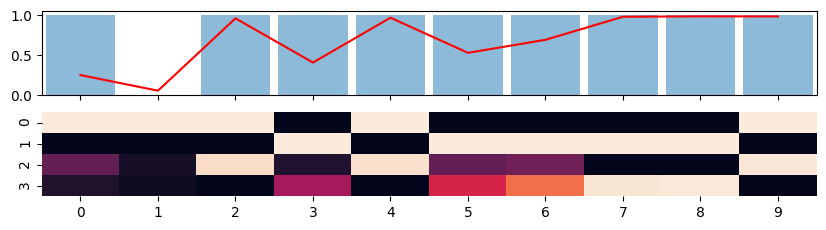

 38%|███▊      | 3/8 [01:06<02:09, 25.90s/it]

===== MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=1) =====
 Ġgun 0.012 {'ĠDenver': 0.118, 'ĠRuby': 0.053, 'Ġthe': 0.012} 	 Ruby gun, Denver juice. Ruby -> gun
*Ġbeer 0.61 {'Ġbeer': 0.61, 'Ġduck': 0.29, 'Ġgun': 0.025} 	 Jordan beer, Ryan duck. Jordan -> beer
 Ġrevolver 0.097 {'Ġjuice': 0.698, 'Ġgun': 0.099, 'Ġrevolver': 0.097} 	 India juice, Raven revolver. Raven -> revolver
 Ġhamb 0.138 {'Ġshotgun': 0.825, 'Ġhamb': 0.138, 'Ġgun': 0.01} 	 Thomas shotgun, Sam hamburger. Sam -> hamburger
 Ġelephant 0.159 {'Ġlemon': 0.819, 'Ġelephant': 0.159, 'Ġle': 0.006} 	 Maria lemon, Israel elephant. Israel -> elephant
*Ġwine 0.962 {'Ġwine': 0.962, 'Ġsheep': 0.013, 'Ġgrape': 0.002} 	 Clark wine, Jessica sheep. Clark -> wine
*Ġplum 0.98 {'Ġplum': 0.98, 'Ġpl': 0.006, 'Ġcoffee': 0.003} 	 Russell plum, Legend coffee. Russell -> plum
*Ġpurple 0.87 {'Ġpurple': 0.87, 'Ġlion': 0.119, 'ĠPurple': 0.002} 	 Andrew purple, Summer lion. Andrew -> purple
*Ġblue 0.605 {'Ġblue': 0.6

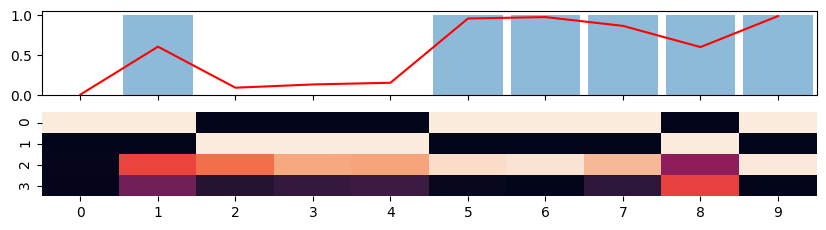

 Ġsheep 0.003 {'ĠMorgan': 0.14, 'ĠZ': 0.027, 'Ġz': 0.022} 	 Ari sheep, Morgan zebra. Ari -> sheep
*Ġdur 0.498 {'Ġdur': 0.498, 'Ġbeer': 0.179, 'Ġz': 0.04} 	 Carter durian, Jessica beer. Carter -> durian
*Ġmouse 0.969 {'Ġmouse': 0.969, 'ĠMouse': 0.013, 'Ġmice': 0.002} 	 Eva mouse, Hunter steak. Eva -> mouse
 Ġsheep 0.005 {'Ġgorilla': 0.69, 'ĠTyler': 0.231, 'Ġgor': 0.008} 	 Tyler gorilla, Dream sheep. Dream -> sheep
*Ġlime 0.993 {'Ġlime': 0.993, 'lime': 0.001, 'ĠLime': 0.001} 	 Thomas lime, Rachel yellow. Thomas -> lime
 Ġbeer 0.03 {'Ġrevolver': 0.932, 'Ġbeer': 0.03, 'Ġgun': 0.014} 	 George revolver, Marco beer. Marco -> beer
 Ġsquirrel 0.089 {'Ġsheep': 0.894, 'Ġsquirrel': 0.089, 'Ġshe': 0.002} 	 Jackson sheep, Cole squirrel. Cole -> squirrel
 Ġhamb 0.145 {'Ġgoat': 0.836, 'Ġhamb': 0.145, 'Ġburger': 0.003} 	 Mario goat, Angel hamburger. Angel -> hamburger
 Ġduck 0.422 {'Ġsoda': 0.564, 'Ġduck': 0.422, 'Ġgoose': 0.001} 	 Eva soda, Robert duck. Robert -> duck
*Ġcannon 0.993 {'Ġcannon': 0.993,

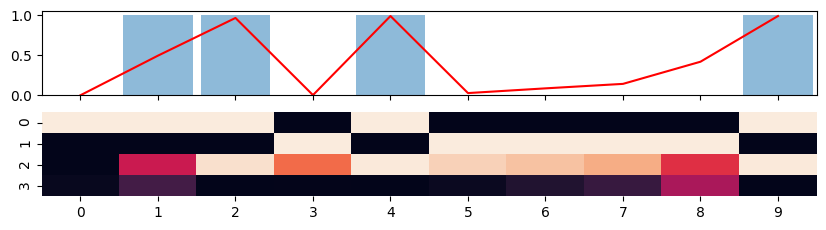

 50%|█████     | 4/8 [01:21<01:26, 21.50s/it]

===== MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0) =====
In query_openai: black: There ->  is black.
In query_openai: chicken: There ->  is chicken.
In query_openai: tea: There ->  is tea.
In query_openai: green: There ->  is green.
In query_openai: tiger: There ->  is a tiger.
In query_openai: pear: There ->  is a pear.
In query_openai: handgun: There ->  is a handgun.
In query_openai: burger: There ->  is a burger.
In query_openai: cake: There ->  is cake.
In query_openai: grenade: There ->  is a grenade.
In query_openai: papaya: There ->  is a papaya.
 Ġanimal 0.0 {'Ġgorilla': 0.22, 'Ġa': 0.179, 'Ġgor': 0.058} 	 Ruby has a gorilla. Ruby's animal
 Ġcolor 0.017 {'Ġanimal': 0.713, 'Ċ': 0.034, 'Ġblack': 0.024} 	 Jose has black. Jose's color
 Ġanimal 0.092 {'Ġcolor': 0.259, 'Ġanimal': 0.092, 'Ġfood': 0.076} 	 Blake has chicken. Blake's animal
 Ġdrink 0.061 {'Ġcolor': 0.407, 'Ġanimal': 0.303, 'Ġdrink': 0.061} 	 Israel has tea. Israel's drink
*Ġcolor

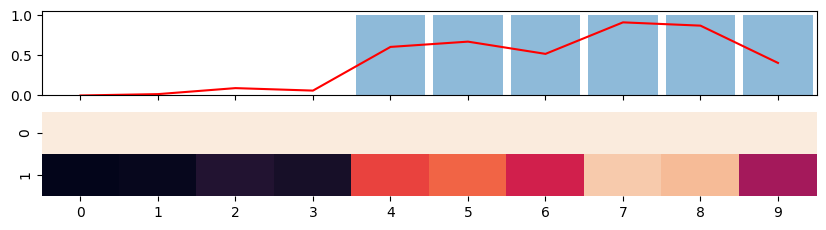

 Ġdrink 0.001 {'Ġwine': 0.255, 'Ġhusband': 0.047, 'Ġa': 0.045} 	 Anna has wine. Anna's drink
 Ġweapon 0.042 {'Ġdrink': 0.215, 'Ġgun': 0.188, 'Ġa': 0.053} 	 Andrew has a handgun. Andrew's weapon
 Ġfruit 0.038 {'Ġdrink': 0.093, 'Ġjuice': 0.083, 'Ġweapon': 0.056} 	 Tony has a lemon. Tony's fruit
*Ġcolor 0.145 {'Ġcolor': 0.145, 'Ġvegetable': 0.09, 'Ġgem': 0.07} 	 Ruby has green. Ruby's color
*Ġfood 0.352 {'Ġfood': 0.352, 'Ġmeal': 0.168, 'Ġmeat': 0.083} 	 Ray has a burger. Ray's food
*Ġcolor 0.476 {'Ġcolor': 0.476, 'Ġhue': 0.056, 'Ġflower': 0.042} 	 April has pink. April's color
 Ġfood 0.115 {'Ġdessert': 0.543, 'Ġtreat': 0.118, 'Ġfood': 0.115} 	 Taylor has cake. Taylor's food
*Ġweapon 0.238 {'Ġweapon': 0.238, 'Ġgrenade': 0.214, 'Ġbomb': 0.071} 	 Raven has a grenade. Raven's weapon
*Ġdrink 0.676 {'Ġdrink': 0.676, 'Ġliquor': 0.074, 'Ġbeverage': 0.06} 	 Joshua has vodka. Joshua's drink
*Ġfruit 0.883 {'Ġfruit': 0.883, 'Ġfood': 0.086, 'Ġcolor': 0.009} 	 Georgia has a papaya. Georgia's fruit
1.11

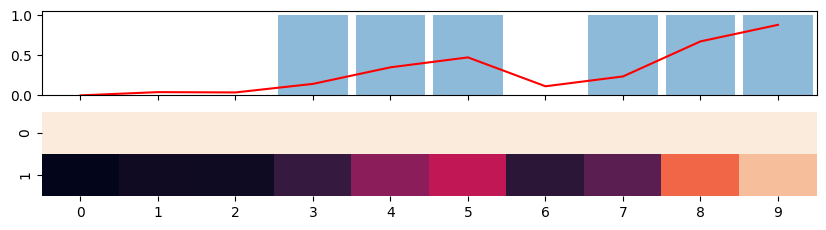

 62%|██████▎   | 5/8 [01:46<01:08, 22.68s/it]

===== MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=1) =====
 Ġanimal 0.0 {'Ġhttp': 0.048, 'Ċ': 0.019, 'Ġpython': 0.015} 	 gorilla -> animal
 Ġcolor 0.015 {'Ġanimal': 0.127, 'Ġblack': 0.11, 'Ġdark': 0.04} 	 black -> color
*Ġanimal 0.441 {'Ġanimal': 0.441, 'Ġfood': 0.201, 'Ġbird': 0.106} 	 chicken -> animal
 Ġdrink 0.267 {'Ġbeverage': 0.374, 'Ġdrink': 0.267, 'Ġcolor': 0.078} 	 tea -> drink
*Ġcolor 0.911 {'Ġcolor': 0.911, 'Ġanimal': 0.024, 'Ġflower': 0.007} 	 pink -> color
*Ġcolor 0.979 {'Ġcolor': 0.979, 'Ġanimal': 0.005, 'Ġcolour': 0.002} 	 purple -> color
*Ġcolor 0.769 {'Ġcolor': 0.769, 'Ġplant': 0.092, 'Ġvegetable': 0.024} 	 green -> color
*Ġanimal 0.966 {'Ġanimal': 0.966, 'Ġwild': 0.008, 'Ġmammal': 0.004} 	 tiger -> animal
*Ġanimal 0.861 {'Ġanimal': 0.861, 'Ġmammal': 0.019, 'Ġfruit': 0.01} 	 gorilla -> animal
*Ġfruit 0.956 {'Ġfruit': 0.956, 'Ġfood': 0.031, 'Ġvegetable': 0.002} 	 pear -> fruit
0.27513033151626587


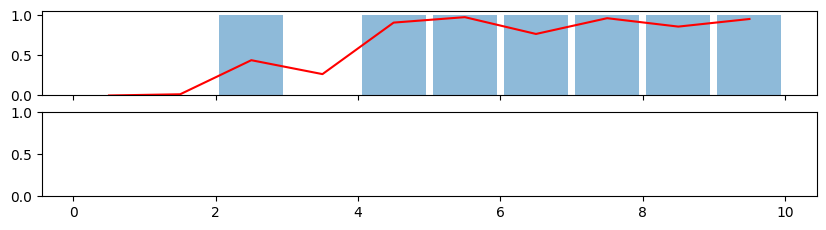

 Ġdrink 0.0 {'Ġhttp': 0.024, 'Ġ/': 0.017, 'Ġub': 0.016} 	 wine -> drink
 Ġweapon 0.069 {'Ġgun': 0.359, 'Ġhandgun': 0.108, 'Ġpistol': 0.092} 	 handgun -> weapon
 Ġfruit 0.157 {'Ġlemon': 0.32, 'Ġfruit': 0.157, 'Ġcitrus': 0.147} 	 lemon -> fruit
*Ġcolor 0.417 {'Ġcolor': 0.417, 'Ġcolour': 0.128, 'Ġfruit': 0.05} 	 green -> color
*Ġfood 0.854 {'Ġfood': 0.854, 'Ġmeat': 0.048, 'Ġmeal': 0.021} 	 burger -> food
*Ġcolor 0.882 {'Ġcolor': 0.882, 'Ġfruit': 0.028, 'Ġflower': 0.012} 	 pink -> color
*Ġfood 0.809 {'Ġfood': 0.809, 'Ġdessert': 0.124, 'Ġfruit': 0.014} 	 cake -> food
*Ġweapon 0.814 {'Ġweapon': 0.814, 'Ġbomb': 0.036, 'Ġexplosive': 0.021} 	 grenade -> weapon
*Ġdrink 0.848 {'Ġdrink': 0.848, 'Ġbeverage': 0.051, 'Ġalcohol': 0.038} 	 vodka -> drink
*Ġfruit 0.957 {'Ġfruit': 0.957, 'Ġfood': 0.035, 'Ġdrink': 0.001} 	 papaya -> fruit
0.25506433844566345


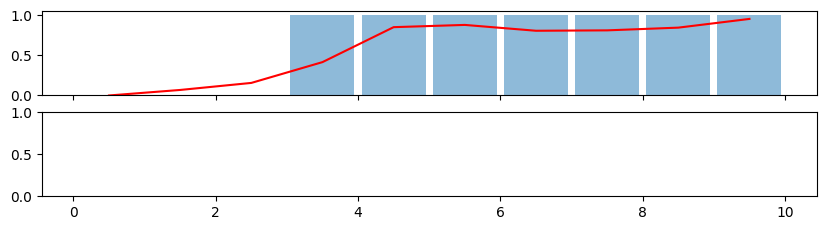

 75%|███████▌  | 6/8 [01:55<00:36, 18.10s/it]

===== MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0) =====
In query_openai: pizza: There ->  is a pizza.
In query_openai: kangaroo: There ->  is a kangaroo.
In query_openai: meat: There ->  is meat.
In query_openai: spaghetti: There ->  is spaghetti.
In query_openai: donkey: There ->  is a donkey.
In query_openai: pineapple: There ->  is a pineapple.
In query_openai: red: There ->  is a red apple.
 Ġfood 0.001 {'Ġpizza': 0.299, 'Ġgrenade': 0.114, 'Ġa': 0.093} 	 Ruby has a pizza. Denver has a grenade. Ruby's food
*Ġfood 0.67 {'Ġfood': 0.67, 'Ġdrink': 0.044, 'Ġburger': 0.044} 	 Robin has a burger. Steven has a lime. Robin's food
 Ġdrink 0.002 {'Ġfood': 0.975, 'Ċ': 0.005, 'Ġdrink': 0.002} 	 Jennifer has a lion. Neil has tea. Neil's drink
 Ġanimal 0.003 {'Ġfood': 0.563, 'Ġfruit': 0.22, 'Ġdrink': 0.068} 	 Jacob has a kangaroo. Egypt has a papaya. Jacob's animal
 Ġcolor 0.148 {'Ġfruit': 0.315, 'Ġfood': 0.219, 'Ġcolor': 0.148} 	 Steven has green. Cole has

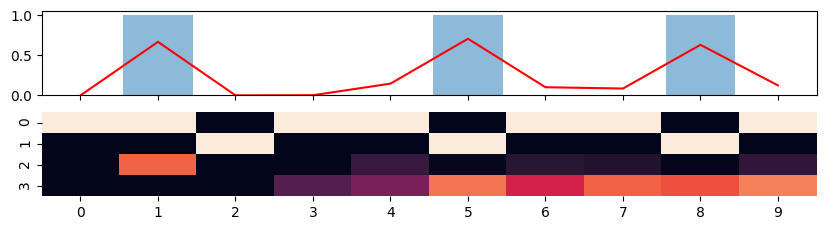

 Ġfood 0.002 {'Ġa': 0.072, 'Ġgot': 0.058, 'Ġthe': 0.031} 	 Ari has meat. Morgan has a shotgun. Ari's food
 Ġweapon 0.02 {'Ġfood': 0.359, 'Ġgun': 0.07, 'Ġcake': 0.056} 	 Carter has a grenade. Jessica has cake. Carter's weapon
 Ġfood 0.24 {'Ġweapon': 0.354, 'Ġfood': 0.24, 'Ġgun': 0.027} 	 Hunter has a mouse. Eva has spaghetti. Eva's food
*Ġfood 0.836 {'Ġfood': 0.836, 'Ġweapon': 0.071, 'Ġmeal': 0.012} 	 Blake has a lime. India has a pizza. India's food
 Ġfruit 0.002 {'Ġfood': 0.519, 'Ġweapon': 0.341, 'Ġpet': 0.011} 	 Jamie has a pear. Raven has a donkey. Jamie's fruit
*Ġfood 0.61 {'Ġfood': 0.61, 'Ġmeat': 0.245, 'Ġmeal': 0.024} 	 George has a pineapple. Marco has a steak. Marco's food
*Ġweapon 0.744 {'Ġweapon': 0.744, 'Ġfood': 0.092, 'Ġgun': 0.027} 	 August has wine. Albert has a gun. Albert's weapon
 Ġcolor 0.132 {'Ġfood': 0.596, 'Ġcolor': 0.132, 'Ġfruit': 0.029} 	 Mario has a goat. Angel has pink. Angel's color
*Ġfood 0.536 {'Ġfood': 0.536, 'Ġcolor': 0.155, 'Ġfruit': 0.129} 	 Robert has 

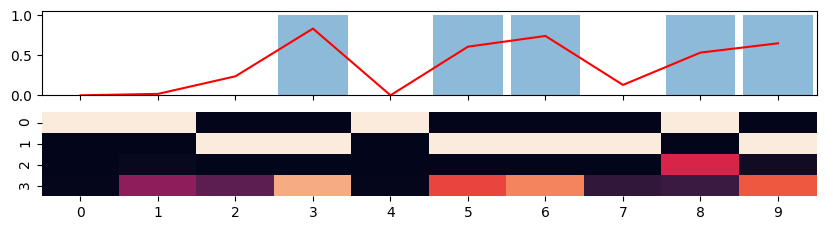

 88%|████████▊ | 7/8 [02:21<00:20, 20.65s/it]

===== MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=1) =====
 Ġfood 0.0 {'ĠDenver': 0.24, 'ĠGrenade': 0.042, 'Ġgrenade': 0.036} 	 Ruby pizza, Denver grenade. Ruby -> food
 Ġfood 0.226 {'Ġburger': 0.23, 'Ġfood': 0.226, 'Ġbeer': 0.014} 	 Robin burger, Steven lime. Robin -> food
 Ġdrink 0.01 {'Ġfood': 0.754, 'Ġtea': 0.012, 'Ġdrink': 0.01} 	 Jennifer lion, Neil tea. Neil -> drink
 Ġanimal 0.038 {'Ġfood': 0.533, 'Ġdrink': 0.202, 'Ġfruit': 0.081} 	 Jacob kangaroo, Egypt papaya. Jacob -> animal
 Ġcolor 0.026 {'Ġfruit': 0.568, 'Ġfood': 0.207, 'Ġplant': 0.069} 	 Steven green, Cole blueberries. Steven -> color
 Ġweapon 0.068 {'Ġfruit': 0.581, 'Ġmonth': 0.116, 'Ġweapon': 0.068} 	 Royal durian, June pistol. June -> weapon
*Ġdrink 0.587 {'Ġdrink': 0.587, 'Ġanimal': 0.151, 'Ġfood': 0.099} 	 Lee whiskey, Jake kangaroo. Lee -> drink
*Ġweapon 0.661 {'Ġweapon': 0.661, 'Ġcolor': 0.119, 'Ġdrink': 0.045} 	 Andrew handgun, Summer black. Andrew -> weapon
*Ġweapon 0.905 {'Ġ

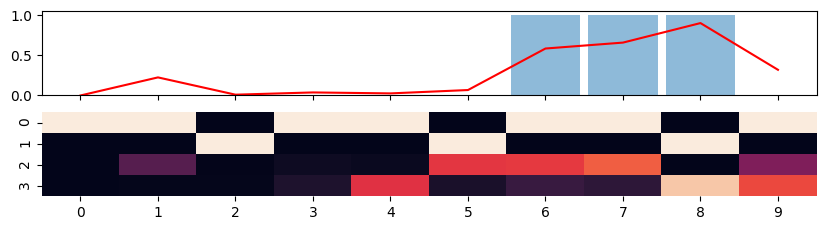

 Ġfood 0.001 {'ĠMorgan': 0.075, 'ĠAri': 0.025, 'Ġshotgun': 0.021} 	 Ari meat, Morgan shotgun. Ari -> food
 Ġweapon 0.005 {'Ġfood': 0.195, 'Ġcake': 0.17, 'Ġgrenade': 0.062} 	 Carter grenade, Jessica cake. Carter -> weapon
*Ġfood 0.663 {'Ġfood': 0.663, 'Ġweapon': 0.101, 'Ġmouse': 0.039} 	 Hunter mouse, Eva spaghetti. Eva -> food
*Ġfood 0.559 {'Ġfood': 0.559, 'Ġweapon': 0.33, 'Ġpizza': 0.006} 	 Blake lime, India pizza. India -> food
 Ġfruit 0.004 {'Ġweapon': 0.557, 'Ġfood': 0.319, 'Ġanimal': 0.013} 	 Jamie pear, Raven donkey. Jamie -> fruit
*Ġfood 0.589 {'Ġfood': 0.589, 'Ġmeat': 0.194, 'Ġweapon': 0.058} 	 George pineapple, Marco steak. Marco -> food
*Ġweapon 0.763 {'Ġweapon': 0.763, 'Ġfood': 0.086, 'Ġfruit': 0.02} 	 August wine, Albert gun. Albert -> weapon
 Ġcolor 0.001 {'Ġfood': 0.723, 'Ġfruit': 0.183, 'Ġclothing': 0.014} 	 Mario goat, Angel pink. Angel -> color
*Ġfood 0.394 {'Ġfood': 0.394, 'Ġfruit': 0.285, 'Ġcolor': 0.194} 	 Robert pizza, Eva red. Robert -> food
 Ġdrink 0.142 {'Ġfood'

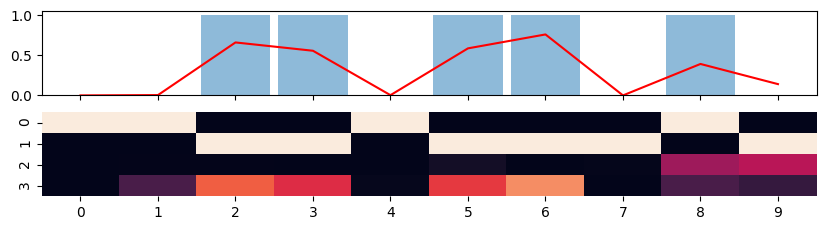

100%|██████████| 8/8 [02:35<00:00, 19.39s/it]


In [47]:
nrows, k_shot = 10, 3
results = {}
for task, cxt_len, abstract in tqdm(list(itertools.product(tasks[-2:], [1, 2], [0, 1]))):
    seed(42)
    args = dict(cxt_len=cxt_len, abstract=abstract)
    res_key = f"{task2str(task)} ({', '.join(f'{k}={v}' for k, v in args.items())})"
    # if not ('TreeSet.equal' in res_key and cxt_len == 1): continue
    
    batch_size = 2; verbose = batch_size <= 2
    if verbose: print(f'===== {res_key} =====')
    all_examples, texts, bos_tokens = zip(*[generate(task, verbose=False, plot=False, nrows=nrows, **args)
                                            for i in range(batch_size)])
    result = Result(task, args, all_examples, texts)
    results[res_key] = result

    data_tuples, eval_results = zip(*[predict(model, tokenizer, text, examples,
        k_shot=k_shot, bos_token=bos_tokens[0], verbose=verbose)
        for text, examples in zip(texts, all_examples)])
    result.data_tuples = data_tuples
    loss, acc, *_ = zip(*eval_results)
    result.mean_loss = np.array(loss).mean()
    result.mean_acc = np.array(join_lists(acc)).mean()
    # continue

    if getattr(result, 'root', None) is None:
        si = -1
        root = node = Node('[-1] root'); node.data = AttrData(step=si)
        nodes = {}; nodes[si] = node
        result.root = root; result.node = node
    node, root = result.node, result.root
    attn_patterns = ['bos->ans0]']
    scores = {ap: reduce_objects([get_head_matching_scores(dt, ap, k_shot=k_shot) for dt in data_tuples])
            for ap in attn_patterns}
    attr = reduce_objects([attribute_step(model, dt, node, root) for dt in data_tuples], fields=['head', 'mlp'])
    # plot_attr(attr, attr); topk_md(attr.head, 10)
    node.data.scores = scores; node.data.attr = attr

In [677]:
for key, result in results.items(): print(f"{key}: {result.mean_loss:.3f}, {result.mean_acc}")

MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=1, abstract=0): 0.036, 1.0
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=1, abstract=1): 0.103, 0.95
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0): 0.687, 0.85
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=1): 0.914, 0.55
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0): 0.686, 0.7
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=1): 0.345, 0.85
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0): 1.882, 0.5
MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=1): 1.618, 0.45


Jake has a goat. Jake's animal
Michelle has a burger. Michelle's food
Denver has black. Denver's col


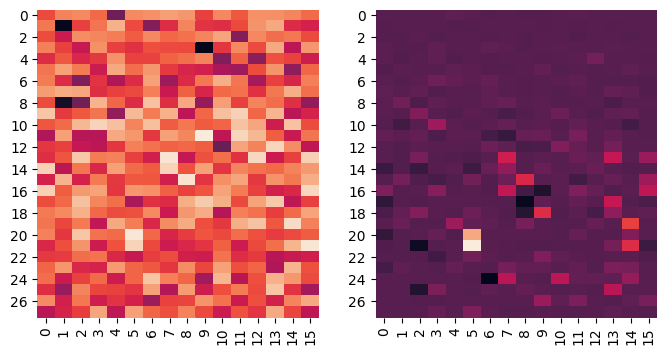

(array([11, 20, 21, 13, 15, 19, 13, 16, 11, 12]),
 array([ 9,  5, 15,  7,  8, 14, 12, 15, 11, 13]),
 array([-0.347103  , -0.45886183, -0.5057017 , -0.5403425 , -0.5448823 ,
       -0.71040034, -0.8066535 , -0.8071772 , -0.8180653 , -0.8305435 ],
      dtype=float32))
(array([21, 20, 19, 21, 18, 15, 13, 17, 13, 16]),
 array([ 5,  5, 14, 14,  9,  8,  7, 13, 13,  7]),
 array([1.1519753 , 0.8907822 , 0.5561121 , 0.490423  , 0.48823094,
       0.47483376, 0.42185324, 0.383546  , 0.38082394, 0.3677672 ],
      dtype=float32))


In [680]:
res_key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=1, abstract=0)'
result = results[res_key]; print(result.texts[-1][:100])
data = result.node.data; plot_attrs([data.scores['bos->ans0]'], data.attr.head], topk=10)

Miller has bread. Victoria has a wolf. Miller's bread
Dallas has a rifle. Gary has a monkey. Dallas'


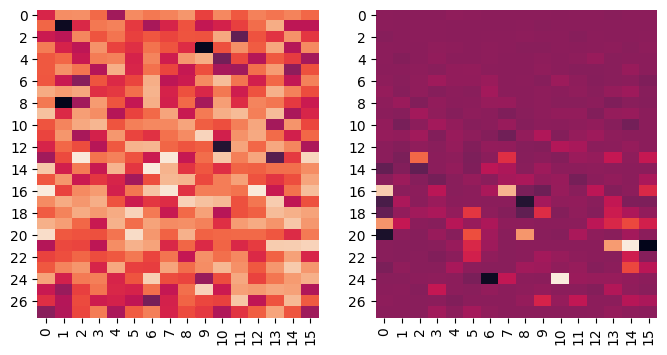

(array([14, 16, 13, 16, 13, 16, 20, 20, 13, 11]),
 array([ 6,  0,  2, 12,  7,  7,  0,  5, 15,  9]),
 array([-0.66314423, -0.66611445, -0.7126825 , -0.72434723, -0.75479513,
       -0.81682897, -0.947729  , -1.0037925 , -1.1067693 , -1.1575141 ],
      dtype=float32))
(array([21, 24, 16, 16, 21, 20, 19, 13, 20, 19]),
 array([14, 10,  0,  7, 13,  8,  0,  2,  5, 14]),
 array([0.89863586, 0.89696443, 0.7813829 , 0.7014873 , 0.6150707 ,
       0.598686  , 0.59143114, 0.4560123 , 0.38756093, 0.37186277],
      dtype=float32))


In [681]:
res_key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.equal) (cxt_len=2, abstract=0)'
result = results[res_key]; print(result.texts[-1][:100])
data = result.node.data; plot_attrs([data.scores['bos->ans0]'], data.attr.head], topk=10)

Roman has pink. Taylor has a pistol. Roman's color
Neil has chips. Johnny has a cocktail. Neil's foo


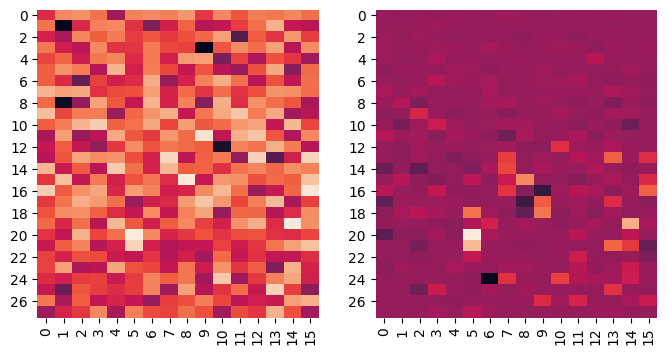

(array([20, 19, 15, 16, 11, 13, 13, 21, 13, 25]),
 array([ 5, 14,  8, 15,  9,  7, 15,  5, 12, 13]),
 array([-0.75702083, -0.7711637 , -0.84612894, -0.8788339 , -0.9587417 ,
       -1.1652749 , -1.2318909 , -1.2553158 , -1.3003385 , -1.3017366 ],
      dtype=float32))
(array([20, 21, 19, 15, 18, 18, 21, 16, 13, 17]),
 array([ 5,  5, 14,  8,  9,  5, 13, 15, 13,  9]),
 array([0.64355063, 0.50835526, 0.48002735, 0.38734782, 0.34307623,
       0.33735344, 0.3099807 , 0.29797995, 0.29742962, 0.29202503],
      dtype=float32))


In [682]:
res_key = 'MlM_gen(persons.EqSet.equal, types_of_things.TreeSet.parent) (cxt_len=2, abstract=0)'
result = results[res_key]; print(result.texts[-1][:100])
data = result.node.data; plot_attrs([data.scores['bos->ans0]'], data.attr.head], topk=10)

[(0, 4), (2, 2), (1, 2)]


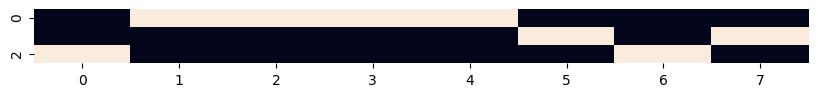

[(2, 3), (1, 3), (0, 2)]


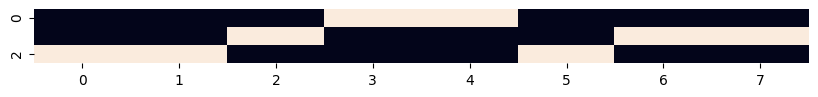

[(1, 3), (2, 3), (0, 2)]


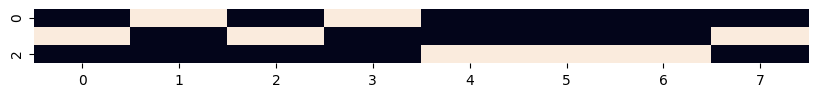

Mac has a monkey. Steven has a bomb. Ari has a grape. Steven's weapon
Christian has a peach. Carter has a car. Laura has a sofa. Christian's fruit
Adam has a pair of pants. Justice has a bed. Laura has a cherry. Justice's furniture
June has a dress. Mario has a carriage. Elsa has a bus. June's clothing
Charlie has an apricot. Edward has a helicopter. Carter has a daisy. Carter's flower
Taylor has a durian. Andy has a kangaroo. August has a bed. August's furniture
Crystal has a strawberry. Dallas has a sofa. Charles has a rabbit. Charles's animal
James has a ship. Egypt has a lime. Jamie has a cat. Egypt's fruit



In [79]:
batch_size = 3
task = tasks[-1]
args = dict(cxt_len = 3, nrows = 8, k_shot = 3, abstract = 0)
all_examples, texts = zip(*[generate(task, verbose=i == batch_size - 1, **args) for i in range(batch_size)])
bos_token, eos_token = (lget(task, 4, '?'), lget(task, 6, None)) \
    if abstract == 0 else (abstract_bos_token, None)

[(2, 5), (0, 3), (1, 2)]


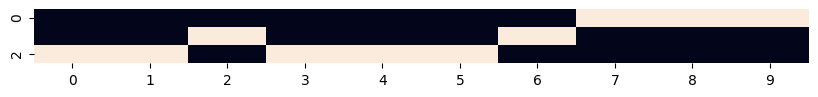

[(1, 5), (0, 3), (2, 2)]


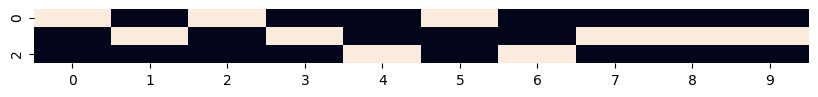

[(0, 4), (1, 4), (2, 2)]


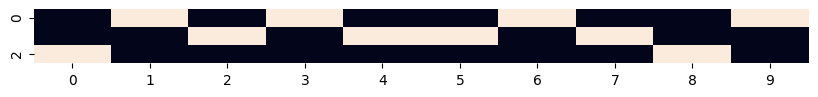

Jamie has a mango. Forest has a rifle. James has a sunflower. James's flower
Jessica has a ship. Ari has a watermelon. Emily has a pair of pliers. Jessica's vehicle
India has a pineapple. Morgan has a couch. Cal has a bicycle. Morgan's furniture
Ray has a beetle. Warren has a awl. Roman has a peach. Ray's insect
Amy has a lime. Ruby has a subway. John has a dog. Ruby's vehicle
Chelsea has a dress. Jake has a goat. June has a hammer. Jake's animal
Faith has a lion. Tyler has a pair of pliers. Jamie has a dryer. Faith's animal
Andrew has a car. Jennifer has a sword. Mario has a pineapple. Jennifer's weapon
Wilson has a blackberry. Marco has a peach. Jack has a grenade. Jack's weapon
Andy has a spanner. Dallas has a tulip. Hope has a helicopter. Andy's tool



In [27]:
seed(1234+1)
batch_size = 3; texts = []; all_examples = []
for i in range(batch_size):
    task = tasks[-1]; nrows = 10; cxt_len = 3; k_shot = 3; abstract = 0; _bos_token = 'Ġ->'
    vocabs, _examples = make_examples(task, nrows=nrows, cxt_len=cxt_len)
    answer_indices = [cands[0].index(ans) for _, _, cands, (tgt, ans0, ans) in _examples]
    counts = [v for k, v in Counter(answer_indices).most_common()]
    if len(counts) < cxt_len or counts[-1] == 1 or counts[0] > counts[-1] * 3: continue
    if cxt_len > 1 and batch_size < 10:
        print(Counter(answer_indices).most_common())
        label_probs = F.one_hot(torch.LongTensor(answer_indices))
        _ = plt.figure(figsize=(10, 0.7));
        _ = sns.heatmap(label_probs.T, cbar=False); plt.show()
    text = make_input_str(task, vocabs, _examples, abstract=abstract, abstract_bos_token=_bos_token)
    bos_token, eos_token = (lget(task, 4, '?'), lget(task, 6, None)) if abstract == 0 else (_bos_token, None)
    texts.append(text); all_examples.append(_examples)
    if len(texts) == batch_size: print(text[:3000]); break

pmapped batch_predict ... done 0:00:00.000024
 Ġjacket 0.002 {'ĠJonathan': 0.043, 'ĠRaven': 0.036, 'Ċ': 0.014} 	 Kate beetle, Raven microwave, Jonathan jacket. Jonathan -> jacket
*Ġcherry 0.498 {'Ġcherry': 0.498, 'Ġbomb': 0.217, 'Ġspan': 0.125} 	 Walker cherry, Anne bomb, Eric spanner. Walker -> cherry
*Ġtaxi 0.701 {'Ġtaxi': 0.701, 'Ġtiger': 0.05, 'Ġjacket': 0.038} 	 Max taxi, Justice tiger, London jacket. Max -> taxi
 Ġcat 0.081 {'Ġant': 0.807, 'Ġcat': 0.081, 'ĠDream': 0.038} 	 Dream ant, John cat, James train. John -> cat
*Ġpap 0.988 {'Ġpap': 0.988, 'Ċ': 0.002, 'Ġcherry': 0.001} 	 Danny papaya, Paris helicopter, India cherry. Danny -> papaya
*Ġelephant 0.831 {'Ġelephant': 0.831, 'Ġsaw': 0.093, 'Ċ': 0.007} 	 Danny saw, Rose elephant, Matthew goose. Rose -> elephant
 Ġcat 0.038 {'Ġwater': 0.556, 'Ġgoose': 0.358, 'Ġcat': 0.038} 	 Virginia watermelon, Brian goose, Jennifer cat. Jennifer -> cat
*Ġlime 0.994 {'Ġlime': 0.994, 'ĠLime': 0.001, 'Ġlemon': 0.001} 	 Ocean lime, Robin sunflower, J

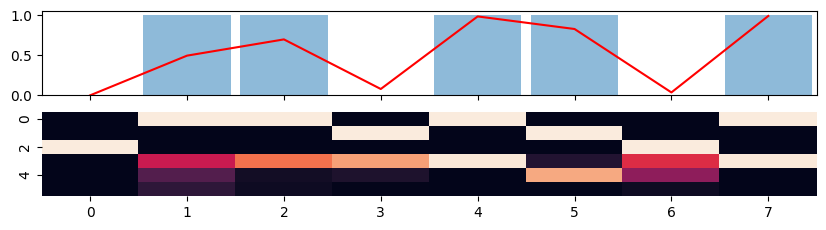

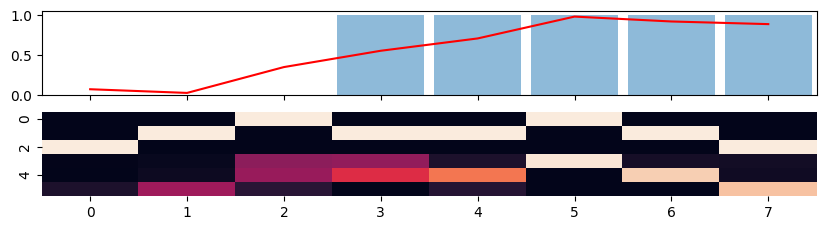

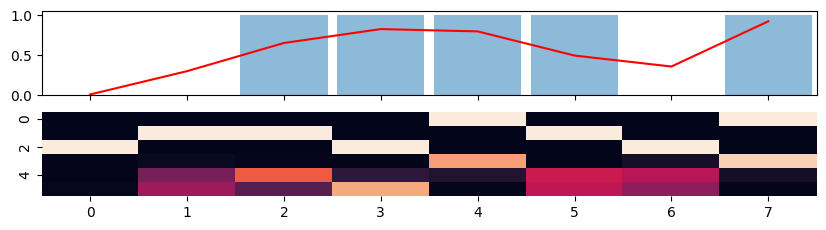

In [334]:
# seed(1234); torch.cuda.empty_cache()
model_names = ['EleutherAI/gpt-j-6B/cpu', 'EleutherAI/gpt-neox-20b', #'EleutherAI/gpt-neox-20b/cpu', 
               'text-curie-001', 'text-davinci-001', 'text-davinci-002'][:1]
metrics = dict(losses=defaultdict(list), accuracies=defaultdict(list))

def batch_predict(model, tokenizer):
    return [predict(model, tokenizer, text, examples, k_shot=k_shot, custom_forward=False, # avoid computing head_inputs
                    bos_token=bos_token, eos_token=eos_token, verbose=len(model_names) == 1)[1]
            for text, examples in zip(texts, all_examples)]
    
with Timer('pmapped batch_predict'):
    parallel = len(model_names) > 1
    pool = Pool(len(model_names)) if parallel else itertools  # with Pool(len(model_names)) as pool:
    results = pool.starmap(batch_predict, [models[model_name] for model_name in model_names])
    if parallel: pool.close(); pool.join()
            
# query2acc, query2loss = defaultdict(list), defaultdict(list)
for model_name, r in zip(model_names, results):
    _, tokenizer = models[model_name]
    for i, (loss, top1_corrects, answer_indices, answer_probs, candidate_probs) in enumerate(r):#.get()
        acc = top1_corrects[k_shot:] # np.array(top1_corrects[k_shot:]).mean()
        metrics['losses'][model_name].append(loss); metrics['accuracies'][model_name].append(acc)
        if batch_size == 1: print(model_name, loss, acc)
#         queries = [e[1] for e in _examples_list[i]][k_shot:]
#         for q, a, l in zip(queries, acc, loss): query2acc[q].append(float(a)); query2loss[q].append(l)
# print(sorted([(q, np.array(v).mean()) for q, v in query2acc.items()], key=lambda x: x[1]))

In [156]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name]).mean())

accuracies EleutherAI/gpt-j-6B/cpu 0.4444444444444444
accuracies EleutherAI/gpt-neox-20b 0.5555555555555556
accuracies text-curie-001 0.3333333333333333
losses EleutherAI/gpt-j-6B/cpu 3.0475401878356934
losses EleutherAI/gpt-neox-20b 2.3752387364705405
losses text-curie-001 5.4890399882962955


In [129]:
def cmp(a, b):
    print(a.dtype, a.size(), b.dtype, b.size())
    print('allclose:', torch.allclose(a, b), 'equal:', torch.equal(a, b))
    print((a == b).float().mean())
    print((a - b).float().abs().mean(), a.float().abs().mean(), b.float().abs().mean())
#     print((a - b).max(), (a - b).min())
#     print(a[a - b == (a - b).max()])
#     print(a[a - b == (a - b).min()])

In [47]:
# text, _examples = texts[0], _examples_list[0]
torch.cuda.empty_cache()
if True: #def predict2(model, tokenizer, text, _examples):
    examples, input_ids, tokens, bos_indices, eos_indices, answers, labels = make_data_tuple(
        text, tokenizer, k_shot=k_shot, bos_token=bos_token, eos_token=eos_token)
    candidates = [[tokenizer.encode(' ' + token)[0] for token in cands[0]] for _, _, cands, _ in _examples]
    with torch.no_grad():
        with Timer(): o0 = model(input_ids.to(model.device), output_attentions=True, output_hidden_states=True)
        with Timer(): o1 = forward0(model, input_ids.to(model.device), labels=labels.to(model.device),
                by_head=['head_input0', 'head_output0'], attn_weights=None, output_hidden_states=True)
        for o in [o0, o1]:
            logits = o.logits
            if isinstance(logits, torch.Tensor): logits = logits.to('cpu').float()# softmax on cpu needs float32
            loss, top1_corrects, answer_probs, candidate_probs = show_predictions(
                examples, tokenizer, logits, bos_indices, eos_indices, answers, labels, loss_reduction='none',
                candidates=candidates, k_shot=k_shot, topk=3, verbose=True)
            print('\n')
#     return loss, top1_corrects, answer_probs, candidate_probs

 ... done 0:00:02.348918
 ... done 0:00:01.659792
 ĠJ 0.032 {'Ċ': 0.074, 'ĠS': 0.038, 'Ġ': 0.036} 	 S J Y -> J
*ĠN 0.429 {'ĠN': 0.429, 'ĠR': 0.223, 'ĠA': 0.074} 	 A N R -> N
 ĠC 0.247 {'ĠV': 0.649, 'ĠC': 0.247, 'ĠB': 0.018} 	 B C V -> C
*ĠT 0.443 {'ĠT': 0.443, 'ĠK': 0.393, 'ĠS': 0.085} 	 S T K -> T
*ĠR 0.839 {'ĠR': 0.839, 'ĠT': 0.099, 'ĠA': 0.021} 	 A R T -> R
*ĠH 0.562 {'ĠH': 0.562, 'ĠQ': 0.278, 'ĠE': 0.112} 	 E H Q -> H
*ĠO 0.792 {'ĠO': 0.792, 'ĠF': 0.161, 'ĠN': 0.013} 	 N O F -> O
*ĠA 0.626 {'ĠA': 0.626, 'ĠI': 0.225, 'ĠY': 0.11} 	 Y A I -> A


 ĠJ 0.032 {'Ċ': 0.074, 'ĠS': 0.038, 'Ġ': 0.036} 	 S J Y -> J
*ĠN 0.429 {'ĠN': 0.429, 'ĠR': 0.223, 'ĠA': 0.074} 	 A N R -> N
 ĠC 0.247 {'ĠV': 0.649, 'ĠC': 0.247, 'ĠB': 0.018} 	 B C V -> C
*ĠT 0.443 {'ĠT': 0.443, 'ĠK': 0.393, 'ĠS': 0.085} 	 S T K -> T
*ĠR 0.839 {'ĠR': 0.839, 'ĠT': 0.099, 'ĠA': 0.021} 	 A R T -> R
*ĠH 0.562 {'ĠH': 0.562, 'ĠQ': 0.278, 'ĠE': 0.112} 	 E H Q -> H
*ĠO 0.792 {'ĠO': 0.792, 'ĠF': 0.161, 'ĠN': 0.013} 	 N O F -> O
*ĠA 0.62

In [176]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name]).mean())

accuracies EleutherAI/gpt-j-6B 0.4976851851851852
accuracies EleutherAI/gpt-neox-20b 0.5023148148148148
accuracies text-davinci-001 0.48148148148148145
accuracies text-davinci-002 0.9675925925925926
losses EleutherAI/gpt-j-6B 1.3536101162543572
losses EleutherAI/gpt-neox-20b 1.1634638377252957
losses text-davinci-001 1.687816629922939
losses text-davinci-002 0.1085046497381794


In [136]:
for metric in ['accuracies', 'losses']:
    for model_name in model_names[:]:
        print(metric, model_name, np.array(metrics[metric][model_name])[:,:27].mean())

accuracies EleutherAI/gpt-j-6B 0.6203703703703703
accuracies EleutherAI/gpt-neox-20b 0.7083333333333334
accuracies text-curie-001 0.5879629629629629
losses EleutherAI/gpt-j-6B 1.5619440356433054
losses EleutherAI/gpt-neox-20b 1.0779137232247094
losses text-curie-001 3.1073556870623844


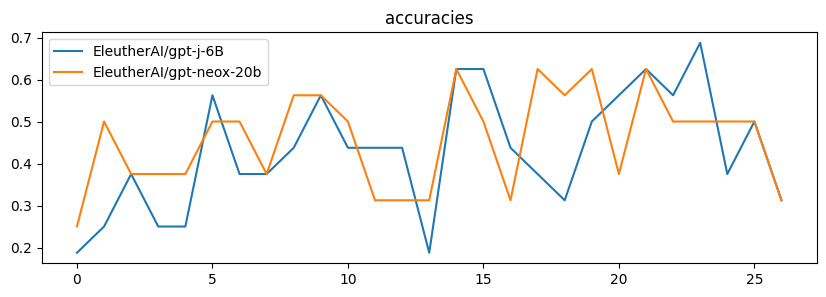

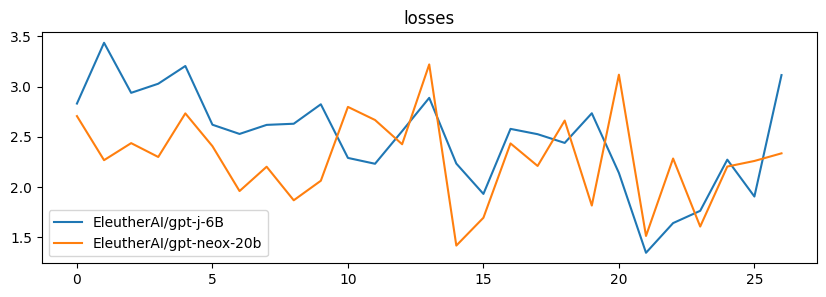

In [191]:
for metric in ['accuracies', 'losses']:
    _ = plt.figure(figsize=(10, 3));
    for model_name in model_names[:2]:
        plt.plot(np.array(metrics[metric][model_name])[:].mean(0), label=f'{model_name}');
    _ = plt.legend();  _ = plt.title(metric); _ = plt.show();

In [11]:
time2prep = {tuple(clock_of_day): 'at', tuple(days_of_week): 'on', tuple(months): 'in'}
def lookup_item2str(item, vocab=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        prep = time2prep[tuple(vocab[0])]
        return f'{item[1]} came {prep} {item[0]}'
    elif vocab[0] == digits:
        return f'{item[1]} is {item[0]}'
def lookup_query2str(query, vocab=None, rel_name=None):
    if vocab[0] in [clock_of_day, days_of_week, months]:
        prep = time2prep[tuple(vocab[0])]
        prep = {'prev': 'just before', 'next': 'just after', 'same': prep}[rel_name]
        return f'Who came {prep} {query}?'
    elif vocab[0] == digits:
        prep = {'prev': 'a year younger than', 'next': 'a year younger than', 'same': ''}[rel_name]
        return f'Who is {prep} {query}'

In [81]:
text = '''Aaren is a boy. Harlow is a girl.
Harlow called Aaren.
Harlow: "Are you a girl?"
Aaren: "'''
model_name = 'EleutherAI/gpt-j-6B'
model, tokenizer = models[model_name]
input_ids = tokenizer.encode(text, return_tensors='pt')
logits = model(input_ids.to(getattr(model, 'device', 'cpu'))).logits

In [80]:
show_topk(*logits[0][-1].softmax(-1).topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

{'Yes': 0.35, 'No': 0.226, 'Yeah': 0.078, 'I': 0.078, 'Y': 0.021}

In [75]:
get_prob_dist(logits.top_logprobs[-1], 5)

{'No': 0.824, 'Yes': 0.115, 'I': 0.04, 'What': 0.006, ' No': 0.003}

In [155]:
text = 'The capital of Canada is'
input_ids = tokenizer(text, return_tensors='pt').input_ids
list(zip(tokenizer.convert_ids_to_tokens(input_ids[0]), input_ids[0].numpy()))
outputs = model.generate(input_ids, max_length=10)
tokenizer.decode(outputs[0], skip_special_tokens=True)

[('▁The', 37),
 ('▁capital', 1784),
 ('▁of', 13),
 ('▁Canada', 1894),
 ('▁is', 19),
 ('</s>', 1)]

'Ottawa. It is the largest city in Canada'

In [478]:
# nrows = 5; k_shot = nrows // 2 + 1
# for pairs in [drop_first_and_last, ]:
nrows = 6;  k_shot = 3
for pairs in reversible_transformations + irreversible_transformations:
    seps = [' -> ', '->'] if random.random() < 0.5 else ['->', ' -> ']
    # seps = [' -> ', ' -> ']
    samples = ['\n' + '\n'.join(a + seps[0] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[0])[0])))
    samples = ['\n' + '\n'.join(b + seps[1] + a for a, b in sample(pairs, nrows)) + '\n' if pairs in reversible_transformations else 
                '\n' + '\n'.join(a + seps[1] + b for a, b in sample(pairs, nrows)) + '\n']
    for s in samples: data_tuples.append(list(make_data_tuple(s, tokenizer, k_shot=k_shot, bos_token=tokenizer.tokenize(seps[1])[0])))

In [ ]:
# # sys.path.insert(0, '/nas/xd/projects/ec')
# from child_utils import loadPBETasks, retrieveJSONTasks
# challenge, challengeCheating = loadPBETasks('/nas/xd/projects/ec/PBE_Strings_Track')
# challenge2, challengeCheating2 = loadPBETasks('/nas/xd/projects/ec/data/sygus')
# tasks = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks.json")
# tasks2 = retrieveJSONTasks("/nas/xd/projects/ec/data/list_tasks2.json")

In [ ]:
from lxy_utils import get_examples_behind, get_examples_before, get_examples_query_before, \
    get_examples_query_behid, get_examples_query_repeat

In [ ]:
reversible_transformations = [list(digit2cardinal.items()), noun2adj, lxy, verb_form, country2capital, en2fr, antonyms]
irreversible_transformations = [capabilities]

In [197]:
losses = []
for model_name, (model, tokenizer) in models.items():
    if any(model_name.startswith(s) for s in ['gpt2-', 'KoboldAI/fairseq-dense', 'text-davinci-001', ]): continue
    if not model_name == 'EleutherAI/gpt-j-6B': continue
    if not isinstance(model, types.FunctionType): _ = model.eval()
    with Timer(model_name): outputs = model(**inputs)
    options_ids_list = [[tokenizer.encode(' ' + option)[0] for option in options] for cxt, query, options, ans in _examples]
    mask_logits_fn = partial(mask_logits, indices=bos_indices, kept_ids=options_ids_list)
    loss, all_top1_correct = show_predictions(text, examples, tokenizer, outputs.logits, bos_indices, eos_indices, answers, labels,
                    mask_logits_fn=None, topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t')
    print(loss, all_top1_correct, '\n')
    losses.append(loss.item() if hasattr(loss, 'item') else loss)
    if model_name == 'EleutherAI/gpt-j-6B': break
print(sum(losses) / len(losses))

EleutherAI/gpt-j-6B ... done 0:00:01
* C 0.842 {' C': 0.842, ' A': 0.041, ' B': 0.04} 	 D -> C
* Thursday 0.778 {' Thursday': 0.778, ' Wednesday': 0.064, ' Friday': 0.063} 	 Friday -> Thursday
* a 0.742 {' a': 0.742, ' c': 0.051, ' A': 0.036} 	 b -> a
* four 0.472 {' four': 0.472, ' three': 0.246, ' one': 0.105} 	 five -> four
tensor(0.3677, grad_fn=<NllLossBackward>) True 

0.3677041530609131


In [24]:
relational_functions = [prev(), next()]
rel_fns = [prevs, nexts]

**TODO: read children books for more posets**  
**TODO: Prompt gpt3 to elicit the posets it knows**  
$x \to f(x)$ where $f \in \{\text{prev/next in posets of numbers/letters/months/days, antonym, hypernym, hyponym, ...}\}$  
$x \to f^2(x)$  
one poset or mixed posets  
$x, f(x).~y \to Ff^{[-1]}(y)$ one poset or mixed posets  
$x, f^k(x).~y \to Ff^{[-1]}(y)~/Ff^{[-]k}(y)$  
$x, f(f(x))~/f(f(x)), x \to f(x)$ in between, the simplest form of sequence completion  
$x, f(x) \to Gf$ where $Gf \in \{<, >\}$  
$x, f(x); y, g(y) \to Ff \stackrel{?}{=} g^{[-1]}$ where $\text{output} \in \{\text{True}, \text{False}\}$  
sort

There is a *natural* monotone map/functor $F$ between posets/sets $A$ and $B$.  Compose the computation (set operations, sorting etc.) between $A$ and $B$ with $F$ to make harder tasks.  
$P(A) ,P(B) \to F(P(A)) \setminus ~/ \cap ~/ \triangle P(B)$. Harder form of set difference/intersection.  
$P(A) \to F(\text{sorted}(P(A)))$. Harder form of sorting.


In [385]:
n_total, n_valid = 192, 64
n_train = n_total - n_valid

input_strs = [make_input_str(tasks[4], nrows=4, ncols=5) for __ in range(n_total)]
for s in sample(input_strs, 3): print(s)

Instruction: replace with the other. For example:
G H G G G -> H G H H H
I I I I M -> M M M M I
A A F A A -> F F A F F
9 9 9 I I -> I I I 9 9

Instruction: replace with the other. For example:
V Q Q V V -> Q V V Q Q
G L L G L -> L G G L G
G 2 2 2 G -> 2 G G G 2
I I Z Z Z -> Z Z I I I

Instruction: replace with the other. For example:
R H H H R -> H R R R H
B 9 9 B B -> 9 B B 9 9
D 2 2 2 D -> 2 D D D 2
A A A A W -> W W W W A



In [368]:
sum(s.count('Yes') for s in input_strs)

370

In [322]:
train_dataset = CHILDDataset(input_strs[:-n_valid], tokenizer)
eval_dataset = CHILDDataset(input_strs[-n_valid:], tokenizer)

In [121]:
if n_total == 1:
    inputs = tokenizer.encode_plus(text, return_tensors='pt')
    inputs = prepare_inputs(inputs, model.device)
    outputs = model(**inputs, output_attentions=False)

    # assert inputs.input_ids.size(0) == 1
    input_ids = inputs.input_ids
    logits = outputs.logits

    bsz = input_ids.size(0); assert bsz == 1
    labels = torch.ones_like(input_ids) * (-100)
    for bi in range(bsz):
        bos_indices = (input_ids[bi] == bos_id).nonzero().squeeze(1)
        eos_indices = (input_ids[bi] == eos_id).nonzero()[-nrows:].squeeze(1)
        for i, (example, bos_i, eos_i) in enumerate(zip(examples, bos_indices.tolist(), eos_indices.tolist())):
            print(' ' + make_example_str(example))
            ans_ids = input_ids[bi, bos_i + 1: eos_i]
            if i >= 2: labels[bi, bos_i: eos_i - 1] = ans_ids
            ans_prob_dist = logits[bi, bos_i: eos_i - 1].softmax(-1)
            ans_probs = ans_prob_dist[torch.arange(ans_prob_dist.size(0)), ans_ids]
            ans_tokens = tokenizer.convert_ids_to_tokens(ans_ids)
            for ans_id, ans_token, ans_prob, dist in zip(ans_ids, ans_tokens, numpy(ans_probs, decimals=3), ans_prob_dist):
                top1_correct = (dist.argmax() == ans_id).item()
                print(('*' if top1_correct else ' ') + ans_token, ans_prob, 
                      show_topk(*dist.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)) 
    loss = nn.CrossEntropyLoss()(logits.view(-1, logits.size(-1)), labels.view(-1))
    loss

In [329]:
training_args = TrainingArguments(output_dir="./models/model_name", 
    overwrite_output_dir=True, do_train=True, do_eval=True,
    per_device_train_batch_size=16, per_device_eval_batch_size=16,
    weight_decay=0.01, adam_beta2=0.98, adam_epsilon=1e-6,
    lr_scheduler_type='constant', learning_rate=5e-3, num_train_epochs=4,
    logging_strategy ='epoch', evaluation_strategy ='epoch', save_steps=0,
    no_cuda=True, report_to='none',  # to avoid report to wandb
)

In [330]:
trainer = Trainer(model, training_args, train_dataset=train_dataset, eval_dataset=eval_dataset,
                  optimizers=(create_optimizer(model, training_args), None))

In [333]:
trainer.place_model_on_device

True

In [ ]:
def get_prev(elem):
    i, v = elem
    return _l[i - 1] if i > 0 else None

false = lambda *_: False
true  = lambda *_: True

In [ ]:
Element = namedtuple('Element', 'index value')
_l = 'A B C B'.split()
n = len(_l)
# l = [Element._make(e) for e in enumerate(l)]
l = seq(_l)
l = l.enumerate().map(Element._make)

In [6]:
l.map(lambda x: {'B': 'D'}.get(x, x))

l.filter(lambda x: get_prev(x) == 'B').select(_.value)

find_fn = _.index == 1
l.filter(find_fn).select(_.value).map(lower)

find_fn = _.value == 'C'
l.filter(find_fn).select(_.index)

# move x to first
update_filter = _.value == 'C'
get_new = lambda x: -1
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# swap first and last
update_filter = true
get_new = lambda x: {0: n - 1, n - 1: 0}.get(x.index, x.index)
l.map(lambda x: Element(update_fn(x, 'index'), x.value)).order_by(_.index).select(_.value)

# get inbetween == drop_while + take_while?

# update by index to its prev
update_filter = _.index == 1
get_new = lambda x: get_prev(x)
def update_fn(x, update_field): return get_new(x) if update_filter(x) else getattr(x, update_field)
l.map(lambda x: Element(x.index, update_fn(x, 'value')))

# if two adjacent elements by indices are equal
l.filter(lambda x: x.index in [0, 1]).select(_.value).distinct().len() == 1

seq('A B C B C'.split()).group_by(_).select(_[1]).flatten()

# count occurance till current
seq('A B A C B A'.split()).inits().reverse().tail().map(lambda x: x.filter(_ == x.last()).len())

# find special
seq('A B A A'.split()).count_by_value().filter(_[1] == 1).select(_[0])

# generalized find special
seq('A A B C C D D'.split()).group_by(_).map(lambda x: (x[0], len(x[1]))).filter(_[1] == 1).select(_[0])